In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from surprise import Dataset, Reader, KNNWithMeans, KNNBasic, SVD, BaselineOnly
from surprise.model_selection import PredefinedKFold, cross_validate
from surprise.accuracy import rmse

In [89]:
df = pd.read_csv('ml-25m/ratings.csv', nrows=500000)
df.drop('timestamp', axis=1, inplace=True)
df.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [90]:
meta_df = pd.read_csv('ml-25m/movies.csv')
meta_df.drop('genres', axis=1, inplace=True)
meta_df['title'] = meta_df['title'].apply(lambda x: re.sub(r'\(\d+\)', '', x))
meta_df['title'] = meta_df['title'].apply(str.strip)
meta_df.head()

,movieId,title
0,1,Toy Story
1,2,Jumanji
2,3,Grumpier Old Men
3,4,Waiting to Exhale
4,5,Father of the Bride Part II


In [96]:
3030 in final_df['movieId'].unique()

True

In [92]:
final_df = df.merge(meta_df, on='movieId')
final_df.head()

,userId,movieId,rating,title
0,1,296,5.0,Pulp Fiction
1,1,306,3.5,Three Colors: Red (Trois couleurs: Rouge)
2,1,307,5.0,Three Colors: Blue (Trois couleurs: Bleu)
3,1,665,5.0,Underground
4,1,899,3.5,Singin' in the Rain


sample_size = 15000
final_df = final_df.sample(n=sample_size, replace=False, random_state=490)

final_df = final_df.reset_index()
final_df = final_df.drop('index',axis=1)

C:\Users\stist\AppData\Local\Temp\ipykernel_21640\2748264790.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i-0.5, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'black')


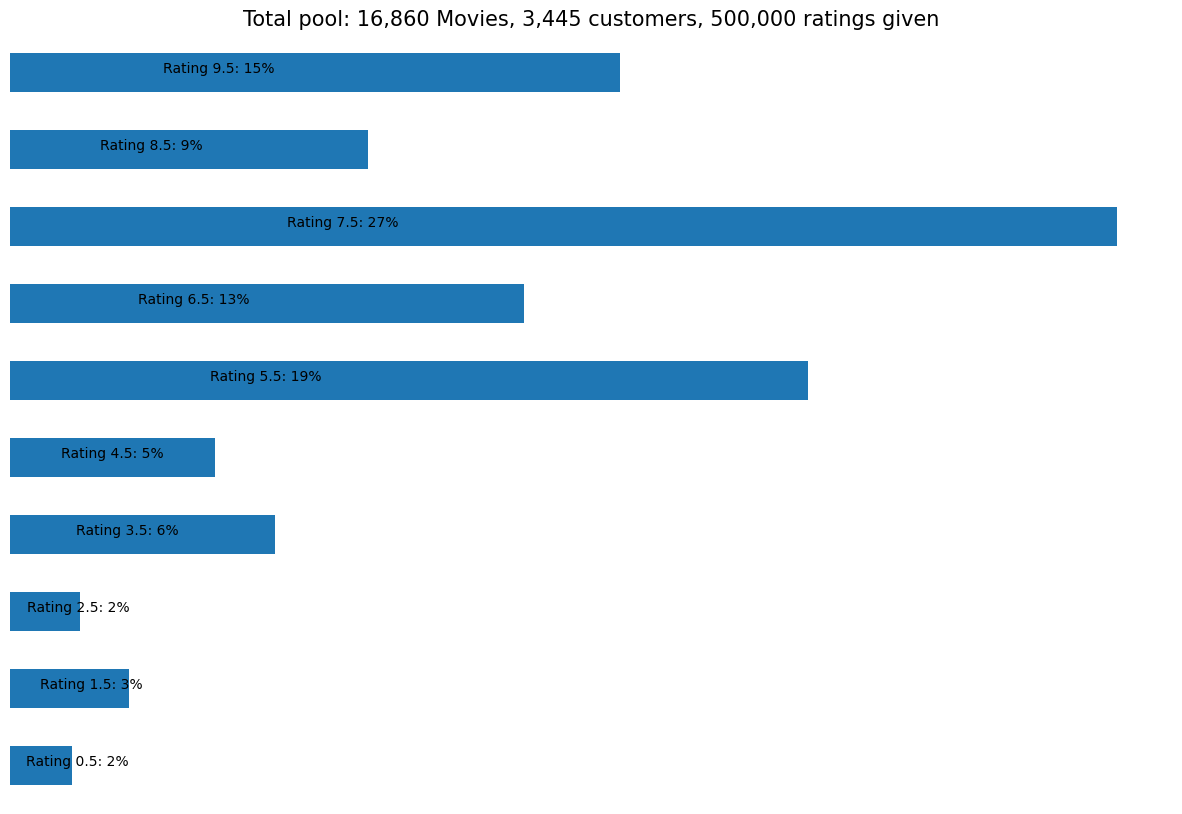

In [32]:
p = final_df.groupby('rating')['rating'].agg(['count'])

# get movie count
movie_count = final_df['title'].nunique()

# get customer count
cust_count = final_df['userId'].nunique()

# get rating count
rating_count = final_df['userId'].count()

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=15)
plt.axis('off')

for i in range(1,11):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i-0.5, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'black')

In [33]:
'''
removing movies with very less (number of) ratings
removing customer who rate less (number of)  movies
'''

f = ['count','mean']

df_movie_summary = final_df.groupby('movieId')['rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Minimum reviews for movie: {}'.format(movie_benchmark))

df_cust_summary = final_df.groupby('userId')['rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Minimum reviews for customer: {}'.format(cust_benchmark))

Minimum reviews for movie: 11.0
Minimum reviews for customer: 129.0


In [34]:
print('Original Shape: {}'.format(final_df.shape))
df = final_df[~final_df['movieId'].isin(drop_movie_list)]
df = final_df[~final_df['userId'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))

Original Shape: (500000, 4)
After Trim Shape: (370943, 4)


In [35]:
'''pivoting df for later'''

df_p = pd.pivot_table(df, values='rating', index='userId', columns='movieId')

In [36]:
meta_df.set_index('movieId', inplace=True)
meta_df.head()

,title
movieId,
1,Toy Story
2,Jumanji
3,Grumpier Old Men
4,Waiting to Exhale
5,Father of the Bride Part II


In [73]:
reader = Reader(rating_scale=(0, 5))

data = Dataset.load_from_df(df[["userId", "movieId", "rating"]], reader)

svd = SVD()

# cross_validate(svd, data, measures=['RMSE', 'MAE'])

models = [
    SVD(),
    KNNBasic(),
    BaselineOnly()
]

# Compare models using cross-validation
for model in models:
    print(f"Evaluating {model.__class__.__name__}...")
    results = cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)
    print("Mean RMSE:", results['test_rmse'].mean())
    print()

Evaluating SVD...
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8405  0.8362  0.8346  0.8372  0.8370  0.8371  0.0019  
Fit time          6.41    5.88    5.85    5.75    6.27    6.03    0.26    
Test time         1.19    0.73    0.71    1.06    1.25    0.99    0.23    
Mean RMSE: 0.8370973923029075

Evaluating KNNBasic...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9017  0.9065  0.9075  0.9072  0.9121  0.9070  0.0033  
Fit time  

In [68]:
user_id = 3446

user_df = meta_df.copy()
user_df = user_df.reset_index()
user_df = user_df[~user_df['movieId'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_df['Estimate_Score'] = user_df['movieId'].apply(lambda x: svd.predict(user_id, x).est)

user_df = user_df.drop('movieId', axis = 1)

user_df = user_df.sort_values('Estimate_Score', ascending=False)
print(user_df.head(10))

                           title  Estimate_Score
314    Shawshank Redemption, The        4.442649
45741            Planet Earth II        4.408320
1119          When We Were Kings        4.358835
840               Godfather, The        4.356955
1231                        Diva        4.344524
16317      Louis C.K.: Chewed Up        4.337859
45593           Band of Brothers        4.320140
40597               Planet Earth        4.319935
43443                   Whiplash        4.314009
49           Usual Suspects, The        4.312621


In [86]:
final_df[final_df['movieId'] == 49274].head()

,userId,movieId,rating,title
609,3,49274,4.0,Happy Feet
6270,43,49274,3.5,Happy Feet
10276,75,49274,3.0,Happy Feet
19705,164,49274,4.0,Happy Feet
40157,318,49274,3.5,Happy Feet
49438,402,49274,3.0,Happy Feet
67115,541,49274,3.0,Happy Feet
78781,606,49274,3.0,Happy Feet
83171,626,49274,3.0,Happy Feet
87648,653,49274,3.5,Happy Feet


In [40]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    
    i = int(meta_df.index[meta_df['title'].str.lower() == movie_title.lower()][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(meta_df).join(df_movie_summary)[['PearsonR', 'title', 'count', 'mean']]
    
    print(corr_target[corr_target['count'] > min_count][:10].to_string(index = False))

In [43]:
import pickle

pickle.dump(svd, open('model.pkl', 'wb'))


In [74]:
df.head()

,userId,movieId,rating,title
70,2,1,3.5,Toy Story
71,2,62,0.5,Mr. Holland's Opus
72,2,110,5.0,Braveheart
73,2,150,4.0,Apollo 13
74,2,151,4.5,Rob Roy


In [78]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

algo = KNNBasic()
algo.fit(data.build_full_trainset())
with open("trained_model.pkl", "wb") as f:
    pickle.dump(algo, f)

Computing the msd similarity matrix...
Done computing similarity matrix.


[(2, 1, 3.5, None),
 (2, 62, 0.5, None),
 (2, 110, 5.0, None),
 (2, 150, 4.0, None),
 (2, 151, 4.5, None),
 (2, 236, 4.0, None),
 (2, 260, 5.0, None),
 (2, 261, 0.5, None),
 (2, 266, 1.0, None),
 (2, 318, 5.0, None),
 (2, 333, 5.0, None),
 (2, 349, 4.5, None),
 (2, 356, 4.5, None),
 (2, 364, 4.5, None),
 (2, 380, 1.0, None),
 (2, 457, 5.0, None),
 (2, 480, 2.0, None),
 (2, 497, 4.0, None),
 (2, 524, 3.5, None),
 (2, 527, 5.0, None),
 (2, 534, 4.5, None),
 (2, 553, 2.0, None),
 (2, 588, 2.0, None),
 (2, 589, 4.0, None),
 (2, 653, 3.0, None),
 (2, 733, 4.5, None),
 (2, 858, 3.5, None),
 (2, 914, 4.0, None),
 (2, 953, 4.5, None),
 (2, 1035, 1.0, None),
 (2, 1080, 1.0, None),
 (2, 1136, 5.0, None),
 (2, 1196, 5.0, None),
 (2, 1197, 5.0, None),
 (2, 1198, 4.0, None),
 (2, 1201, 2.5, None),
 (2, 1210, 5.0, None),
 (2, 1246, 4.0, None),
 (2, 1257, 5.0, None),
 (2, 1270, 4.0, None),
 (2, 1271, 1.5, None),
 (2, 1275, 4.5, None),
 (2, 1283, 4.0, None),
 (2, 1287, 5.0, None),
 (2, 1291, 5.0, None